# Stock price prediction

## Coinbase Global, Inc. (COIN)

In [184]:
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [185]:
## Make time Series 

dataset_filepath = os.getenv('HOME') + '/COIN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
coinbase_ts = df['Close']

print(type(ts))
coinbase_ts.head()

<class 'pandas.core.series.Series'>


Date
2021-05-05    273.000000
2021-05-06    256.760010
2021-05-07    263.700012
2021-05-10    293.450012
2021-05-11    303.000000
Name: Close, dtype: float64

In [186]:
## Preprocessing

coinbase_ts = coinbase_ts.interpolate(method='time')
coinbase_ts[coinbase_ts.isna()]

Series([], Name: Close, dtype: float64)

In [187]:
coinbase_ts_log = np.log(coinbase_ts)

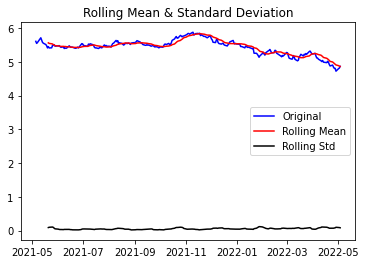

Results of Dickey-Fuller Test:
Test Statistic                  -0.452592
p-value                          0.900941
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


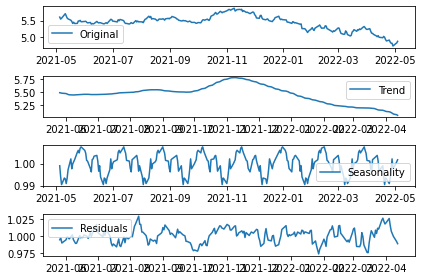

In [188]:
## EDA

# 정성적 그래프 분석
plot_rolling_statistics(coinbase_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(coinbase_ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(coinbase_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(coinbase_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [189]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.526641
p-value                          0.000002
#Lags Used                       8.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


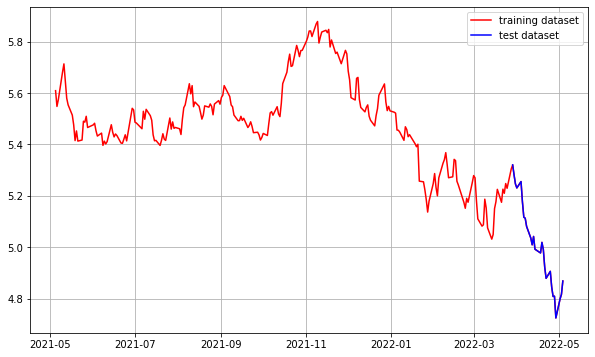

In [190]:
train_data, test_data = coinbase_ts_log[:int(len(coinbase_ts_log)*0.9)], coinbase_ts_log[int(len(coinbase_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(coinbase_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

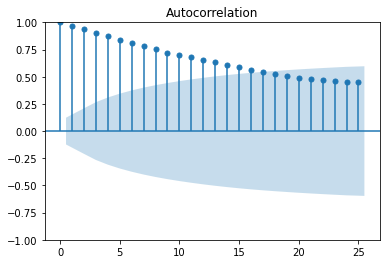

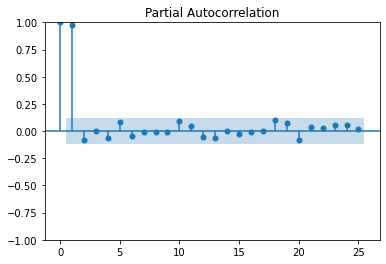

In [191]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(coinbase_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(coinbase_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.490574e+01
p-value                        1.483878e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.490574e+01
p-value                        1.483878e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


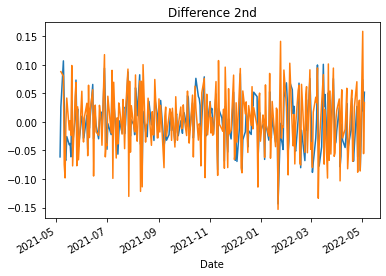

In [192]:
# 차분 안정성 확인 -> d 구하기
diff_1 = coinbase_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

In [193]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 402.285
Date:                Thu, 05 May 2022   AIC                           -798.570
Time:                        14:34:11   BIC                           -788.308
Sample:                             0   HQIC                          -794.428
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7782      0.702      1.109      0.267      -0.597       2.154
ma.L1         -0.8014      0.664     -1.206      0.228      -2.103       0.501
sigma2         0.0017      0.000     11.065      0.0

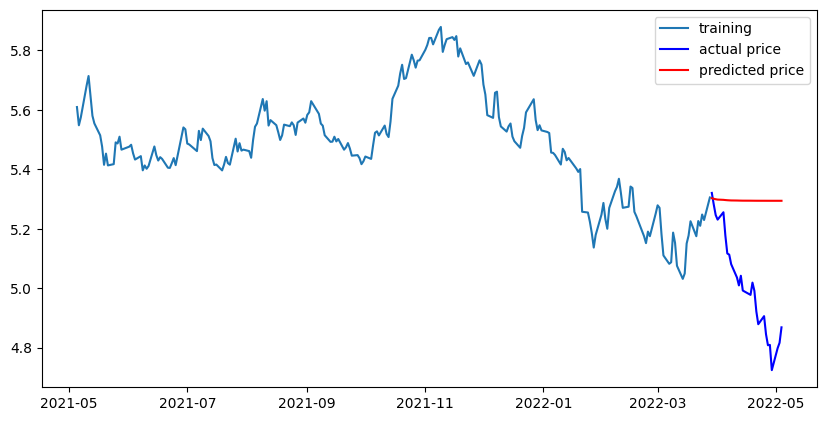

In [194]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [195]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2889.4626116616573
MAE:  47.66707629127332
RMSE:  53.753721840088964
MAPE: 34.93%


## --- Coinbase 회고 ---


여러 값들을 변경해보았지만, 현재 mape가 34.93%이 나오는 (1,1,1)말고는 더 적절한 q, d, p 값을 찾지 못했다.

최근 하락장이 강해서 이런 현상이 있는 것인지.. 변동성이 강한 코인시장이라서 이런 현상이 있는 것인지.. q, d, p 값만으로 해결이 가능한지 궁금하다. 후에도 찾아보고 해결해봐야겠다.


------------------------------------------------------------------------------------------------------------------------

## XRP

In [196]:
## Make time Series 

dataset_filepath = os.getenv('HOME') + '/XRP-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
X_ts = df['Close']

X_ts.head()

Date
2021-05-05    1.614512
2021-05-06    1.600581
2021-05-07    1.581755
2021-05-08    1.562598
2021-05-09    1.535293
Name: Close, dtype: float64

In [197]:
## Preprocessing

X_ts = X_ts.interpolate(method='time')
X_ts[X_ts.isna()]

Series([], Name: Close, dtype: float64)

In [198]:
X_ts_log = np.log(X_ts)

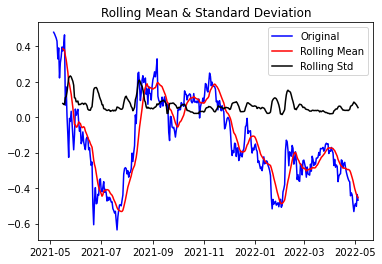

Results of Dickey-Fuller Test:
Test Statistic                  -2.539192
p-value                          0.106227
#Lags Used                       6.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


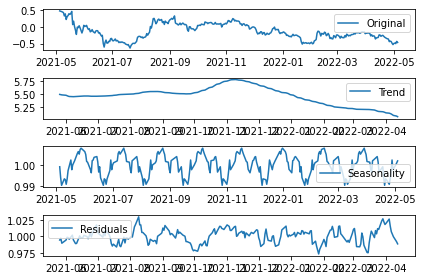

In [209]:
## EDA

# 정성적 그래프 분석
plot_rolling_statistics(X_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(X_ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(coinbase_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(X_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [210]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.526641
p-value                          0.000002
#Lags Used                       8.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


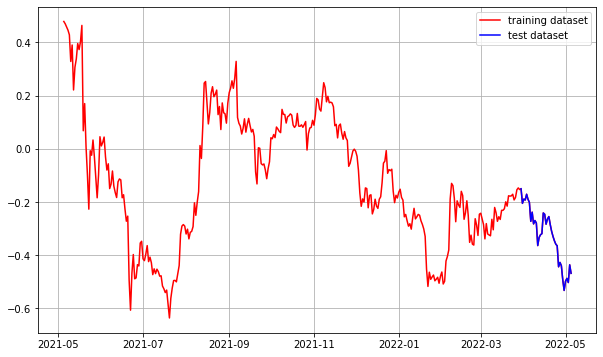

In [211]:
train_data, test_data = X_ts_log[:int(len(X_ts_log)*0.9)], X_ts_log[int(len(X_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(X_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

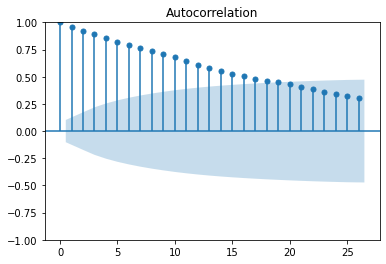

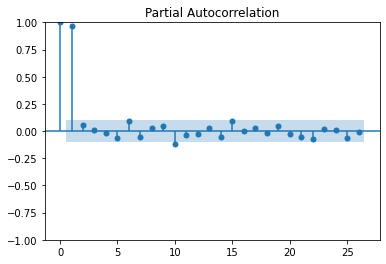

In [212]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(X_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(X_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.972310e+00
p-value                        2.760310e-12
#Lags Used                     5.000000e+00
Number of Observations Used    3.590000e+02
Critical Value (1%)           -3.448697e+00
Critical Value (5%)           -2.869625e+00
Critical Value (10%)          -2.571077e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.972310e+00
p-value                        2.760310e-12
#Lags Used                     5.000000e+00
Number of Observations Used    3.590000e+02
Critical Value (1%)           -3.448697e+00
Critical Value (5%)           -2.869625e+00
Critical Value (10%)          -2.571077e+00
dtype: float64


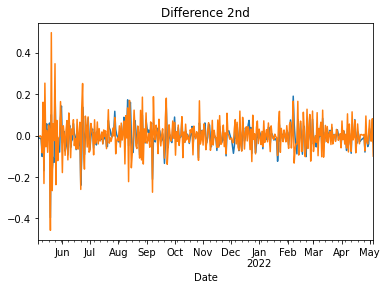

In [213]:
# 차분 안정성 확인 -> d 구하기
diff_1 = X_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

In [214]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 8))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(0, 1, 8)   Log Likelihood                 466.950
Date:                Thu, 05 May 2022   AIC                           -915.899
Time:                        14:37:27   BIC                           -881.762
Sample:                    05-05-2021   HQIC                          -902.279
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0544      0.050     -1.085      0.278      -0.153       0.044
ma.L2         -0.0419      0.040     -1.050      0.294      -0.120       0.036
ma.L3         -0.0199      0.048     -0.412      0.6

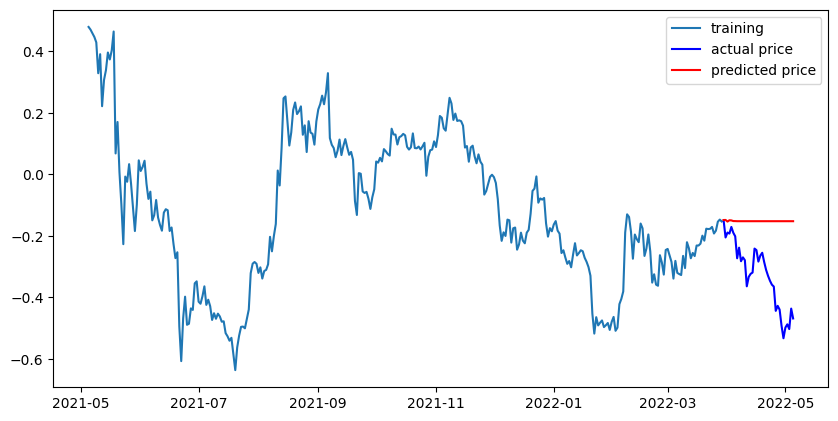

In [215]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [216]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.023037562572993733
MAE:  0.13188530968054524
RMSE:  0.151781298495545
MAPE: 19.46%


## --- XRP 회고 ---


여러 값들을 변경해보았지만, 현재 mape가 19.46%이 나오는 (0,1,8)말고는 더 적절한 q, d, p 값을 찾지 못했다.

최근 하락장이 강해서 이런 현상이 있는 것인지.. 변동성이 강한 코인시장이라서 이런 현상이 있는 것인지.. q, d, p 값만으로 해결이 가능한지 궁금하다. 후에도 찾아보고 해결해봐야겠다.


------------------------------------------------------------------------------------------------------------------------

In [217]:
## Make time Series 

dataset_filepath = os.getenv('HOME') + '/FB.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
FB_ts = df['Close']

FB_ts.head()

Date
2021-05-05    315.019989
2021-05-06    320.019989
2021-05-07    319.079987
2021-05-10    305.970001
2021-05-11    306.529999
Name: Close, dtype: float64

In [218]:
## Preprocessing

FB_ts = FB_ts.interpolate(method='time')
FB_ts[FB_ts.isna()]

Series([], Name: Close, dtype: float64)

In [219]:
FB_ts_log = np.log(FB_ts)

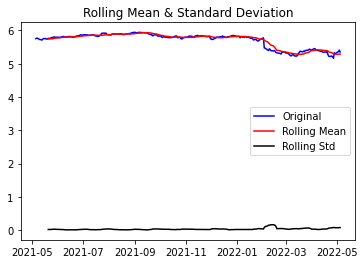

Results of Dickey-Fuller Test:
Test Statistic                  -0.570167
p-value                          0.877582
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


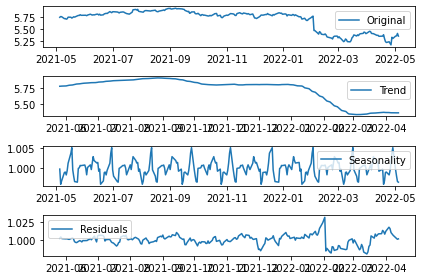

In [220]:
## EDA

# 정성적 그래프 분석
plot_rolling_statistics(FB_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(FB_ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(FB_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(FB_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [221]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.131705
p-value                          0.000012
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


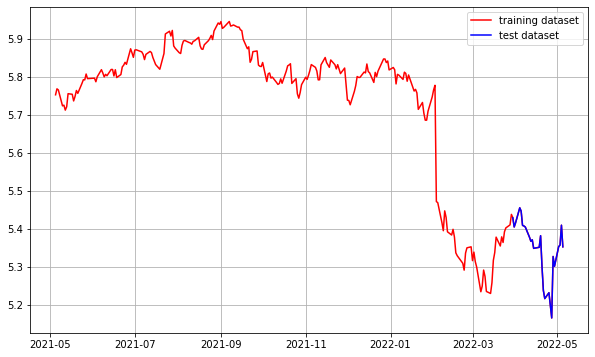

In [223]:
train_data, test_data = FB_ts_log[:int(len(FB_ts_log)*0.9)], FB_ts_log[int(len(FB_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(FB_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

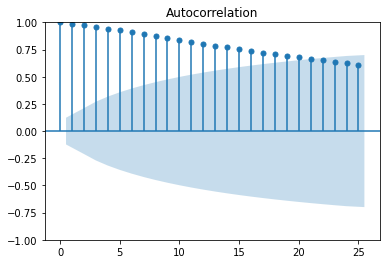

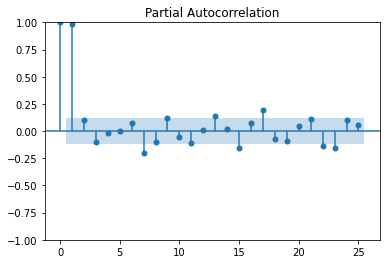

In [224]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(FB_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(FB_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.651653e+01
p-value                        2.082813e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.651653e+01
p-value                        2.082813e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


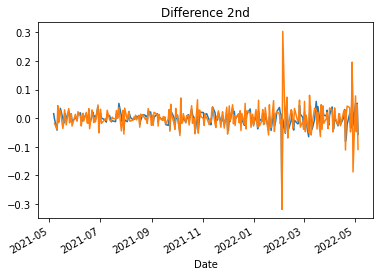

In [225]:
# 차분 안정성 확인 -> d 구하기
diff_1 = FB_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_1)

In [226]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 482.539
Date:                Thu, 05 May 2022   AIC                           -961.079
Time:                        14:39:50   BIC                           -954.229
Sample:                             0   HQIC                          -958.315
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0133      0.133     -0.100      0.920      -0.274       0.248
sigma2         0.0008   1.72e-05     48.372      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

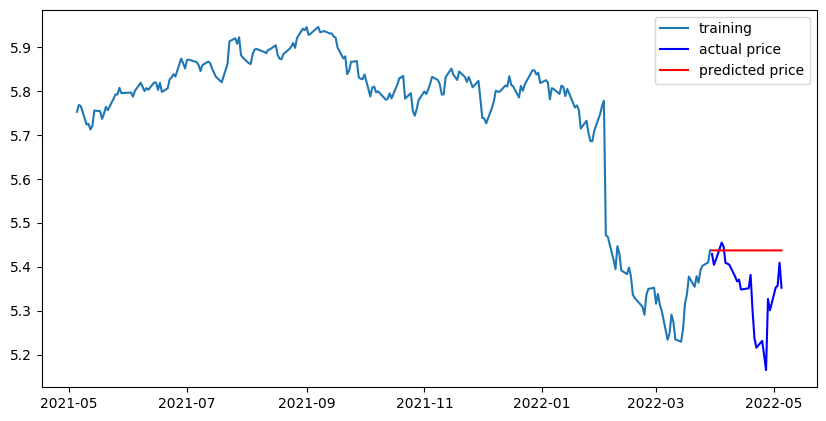

In [227]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [228]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  622.628606662313
MAE:  19.770466839334517
RMSE:  24.95252705964494
MAPE: 10.03%


## --- Meta(FB) 회고 ---


META는 이전 2 종목과 다르게 여러 값들을 변경해본 끝에 현재 mape가 10.03%이 나오는 (1,1,0)이라는 더 적절한 q, d, p 값과 MAPE 값을 잘 찾았다.

## --- 총 회고 ---


안정적이고 충분한 데이터가 있는 알파벳(google)이나 애플 같은 종목보다는 기존에 관심이 있던 역사가 짧은 종목 2개로 모험을 해보았다.

META 전에 했던 COINBASE, XRP는 META처럼 충분한 데이터 기간을 가지고 있지 않아서 적절한 q, d, p 값을 찾기가 어려웠을까라는 생각도 해본다. 왜 적절한 q, d, p 값을 찾기가 어려웠는가에 대해 연구해 볼 생각이다.